In [2]:
# execute this for the 1st time
!pip install -r example-requirements.txt 

#download file 
#!wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

  Using cached tsfresh-0.20.1-py2.py3-none-any.whl (95 kB)
  Using cached stumpy-1.12.0-py3-none-any.whl (169 kB)
  Using cached numba-0.57.1-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached llvmlite-0.40.1-cp39-cp39-win_amd64.whl (27.7 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0


ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [105]:
import os
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd

In [4]:

fname = join(os.getcwd(),'data','data3SS2009.mat') #carrega o arquivo com um dicionário contendo todas as informações

mat_contents = sio.loadmat(fname) #mat_contents é do tipo dict

dataset = mat_contents['dataset'] #na chave 'dataset' estão as informações de entrada que serão tratadas e inseridas no modelo

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc) #na chave 'labels' do dict estão as saidas num array

print(dataset[:,1,:].shape)

(8192, 850)


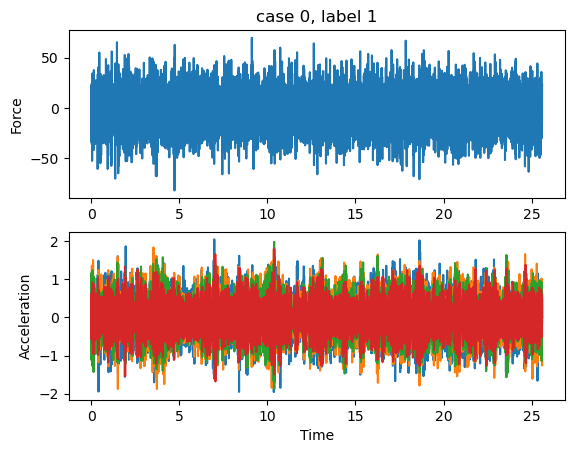

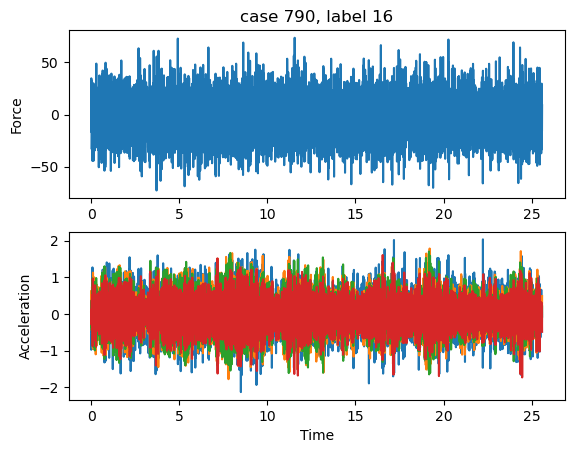

(8192, 850)


In [5]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

print(Ch2.shape)

In [6]:
print(np.linspace(1,N,N))

[1.000e+00 2.000e+00 3.000e+00 ... 8.190e+03 8.191e+03 8.192e+03]


In [18]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

Ch2_ar = np.empty((850,30), float)
Ch3_ar = np.empty((850,30), float)
Ch4_ar = np.empty((850,30), float)
Ch5_ar = np.empty((850,30), float)

for i in range(0,850):
    res2 = AutoReg(Ch2[:,i], lags = 30).fit()
    res3 = AutoReg(Ch3[:,i], lags = 30).fit()
    res4 = AutoReg(Ch4[:,i], lags = 30).fit()
    res5 = AutoReg(Ch5[:,i], lags = 30).fit()
    
    for j in range(0,30):
        Ch2_ar[i,j] = res2.params[1:31][j]
        Ch3_ar[i,j] = res3.params[1:31][j]
        Ch4_ar[i,j] = res4.params[1:31][j]
        Ch5_ar[i,j] = res5.params[1:31][j]
        
#res = AutoReg(Ch2[:,0], lags = 30).fit()
#print(res.params[1:31].shape)
#print(Ch2_ar.shape)


In [28]:
X1=np.concatenate((Ch2_ar, Ch3_ar), axis=1)
X1=np.concatenate((X1, Ch4_ar), axis=1)
X1=np.concatenate((X1, Ch5_ar), axis=1)
X1.shape

(850, 120)

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
pca = PCA()
pca.fit(X1)

PCA()

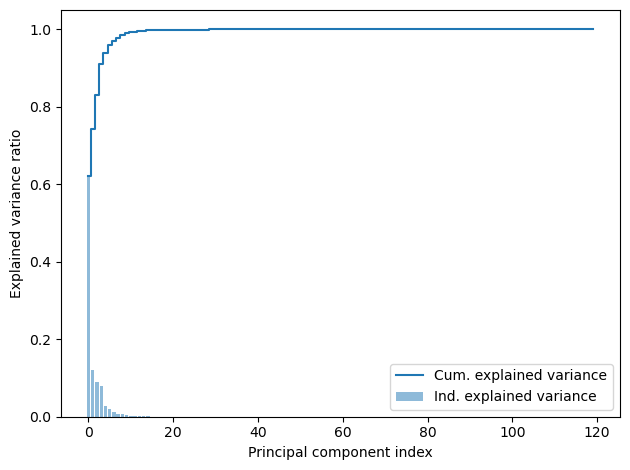

In [89]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [209]:
X1_reduced=pca.fit_transform(X1)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
X2=X1_reduced[:,0:componentes]
X2.shape



(850, 10)

In [216]:
scaler = MinMaxScaler(feature_range=(-1,1))
X1s = scaler.fit_transform(X1)
X2s = scaler.fit_transform(X2)

In [217]:
indDam = y > 9

dfARed = pd.concat([pd.DataFrame(X1s),pd.DataFrame({'target':indDam})], axis=1)
dfPCA = pd.concat([pd.DataFrame(X2s),pd.DataFrame({'target':indDam})], axis=1)

dfPCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.252259,-0.312348,-0.234089,-0.012268,-0.129101,-0.010486,-0.085765,-0.070927,-0.195600,-0.051496
std,0.582303,0.450500,0.235330,0.427847,0.369091,0.354335,0.367925,0.350862,0.289088,0.342202
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.821019,-0.605597,-0.401998,-0.285761,-0.381832,-0.190199,-0.359776,-0.277423,-0.345534,-0.254255
50%,-0.425381,-0.470659,-0.245969,0.039006,-0.206986,-0.029114,-0.119843,-0.072276,-0.167457,-0.007076
75%,0.352603,-0.222179,-0.077091,0.291971,0.142279,0.148971,0.142017,0.119292,-0.041855,0.172943
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


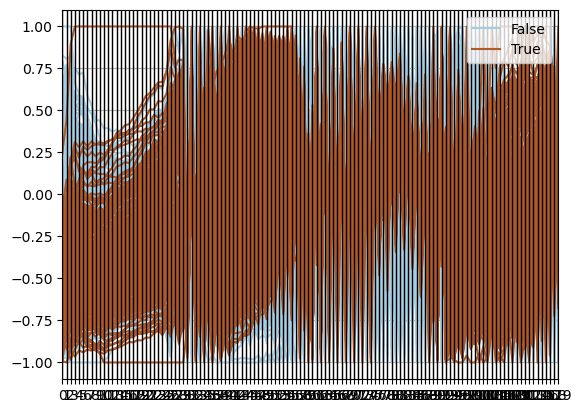

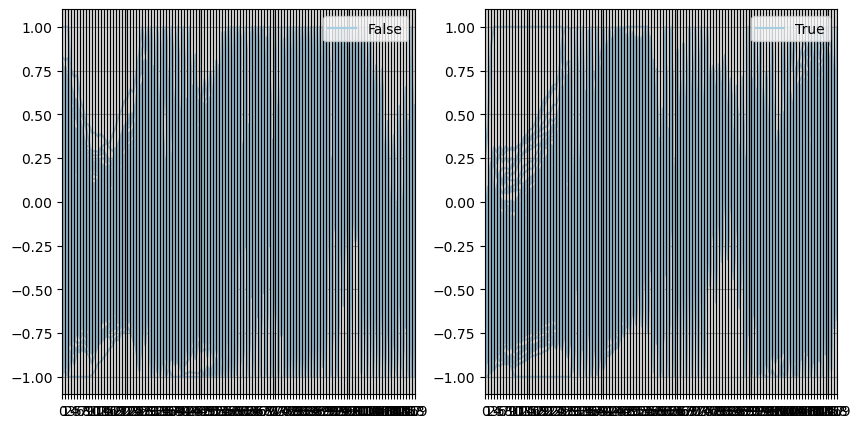

In [218]:
plt.figure()
pd.plotting.parallel_coordinates(dfARed, 'target', colormap=plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(dfARed[dfARed['target']==0], 'target', colormap=plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(dfARed[dfARed['target']==1], 'target', colormap=plt.get_cmap('Paired'))
plt.show()

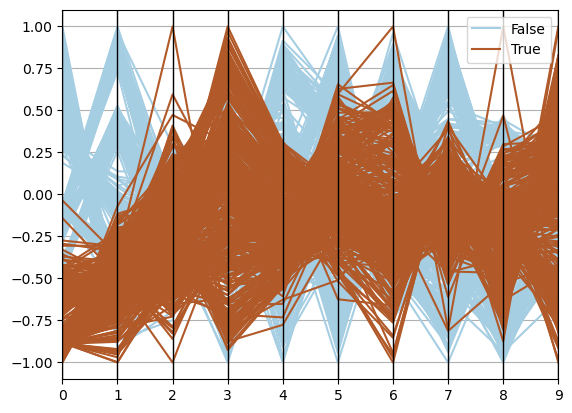

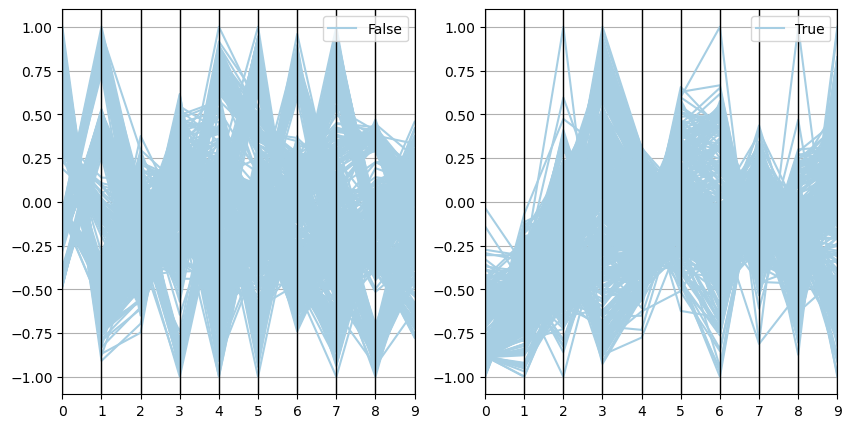

In [219]:
plt.figure()
pd.plotting.parallel_coordinates(dfPCA, 'target', colormap=plt.get_cmap('Paired'))
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
pd.plotting.parallel_coordinates(dfPCA[dfPCA['target']==0], 'target', colormap=plt.get_cmap('Paired'))
plt.subplot(122)
pd.plotting.parallel_coordinates(dfPCA[dfPCA['target']==1], 'target', colormap=plt.get_cmap('Paired'))
plt.show()

In [220]:
#testando Softmax regression com a matriz X1s:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial",max_iter=1000, solver="lbfgs",C=10)
softmax_reg.fit(X1s,y)
print(softmax_reg.n_iter_) #Com os dados da matriz com 120 colunas (30 por canal), o softmax necessita de 328 iterações

[328]


In [222]:
#testando Softmax regression com a matriz X2s:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial",max_iter=200, solver="lbfgs",C=10)
softmax_reg.fit(X2s,y)
print(softmax_reg.n_iter_) #Com os dados da matriz com 10 colunas (reduzida por PCA), o softmax necessita de 103 iterações

[103]


In [202]:
softmax_reg.predict([X1s[790,:]])

array([16], dtype=uint8)

In [223]:
Yh = np.zeros(850)
for i in range(0,850):
    yh = softmax_reg.predict([X2s[i,:]])
    Yh[i]=yh

count = 0    
Evaluation = Yh==y

for j in range(0,850):
    if Evaluation[j]==False:
        count+=1
print(count/850*100)

1.7647058823529411


In [ ]:
# Rodando a Matriz X1 no modelo, que ajustou após 328 iterações, o modelo reproduziu a matriz y na saida yh (100% de acerto)
# Rodando a Matriz X2,no modelo, que ajustou após 103 iterações, o modelo reproduziu a matriz y na saida yh (~98% de acerto)